In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape
from tensorflow.keras import backend as K
import tensorflow as tf

/home/sergeyk/.local/share/virtualenvs/fsdl-text-recognizer-6Tfq_pVK/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [91]:
DATA_DIRNAME = Path('/home/sergeyk/work/iamdb')

crop_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped').glob('*.jpg')))
gt_filenames = sorted(list((DATA_DIRNAME / 'forms-cropped-gt2').glob('*.png')))

X = []
Y = []
for crop_filename in crop_filenames[:2]:
    name = crop_filename.stem
    image = cv2.imread(str(crop_filename), cv2.IMREAD_GRAYSCALE)
    
    gt_filename = DATA_DIRNAME / 'forms-cropped-gt2' / f'{name}.png'
    gt_image = cv2.imread(str(gt_filename), cv2.IMREAD_GRAYSCALE) // 255
    
#     gt_image = cv2.blur(gt_image, (10, 10)) / 255
    
    X.append(np.expand_dims(image / 255, -1))
    Y.append(to_categorical(gt_image, 2))
    
X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.float32)
print(X.shape, X.dtype, Y.shape, Y.dtype)

# For overfitting
X_single = X[0:1]
Y_single = Y[0:1]

# For training
X_train = X[:1000]
Y_train = Y[:1000]
X_test = X[1000:]
Y_test = Y[1000:]

(2, 633, 620, 1) float32 (2, 633, 620, 2) float32


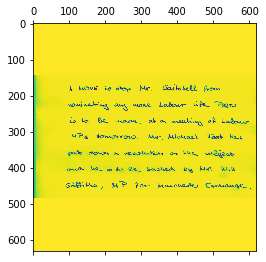

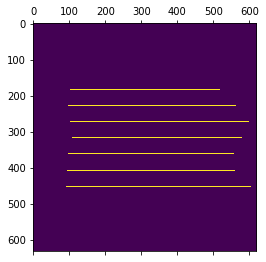

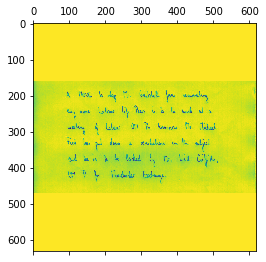

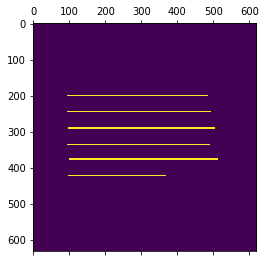

In [96]:
MAX_HEIGHT, MAX_WIDTH, _ = X[0].shape

plt.matshow(X[0].squeeze())
plt.matshow(Y[0].argmax(-1))

plt.matshow(X[1].squeeze())
plt.matshow(Y[1].argmax(-1))

In [101]:
BATCH_NORM = False

input_image = Input((MAX_HEIGHT, MAX_WIDTH, 1))

def conv_block(inputs, num_filters=32, kernel_size=5, dilation_rate=3, activation='relu', batch_norm=BATCH_NORM):
    conv = Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, use_bias=(not batch_norm), padding='same')(inputs)
    if batch_norm:
        conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    return conv
    
conv = conv_block(input_image, 32, 3, 2)
conv = conv_block(conv, 32, 3, 2)

conv2 = conv_block(conv, 16, 5, 1)
concatenated = Concatenate()([conv, conv2])

conv3 = conv_block(concatenated, 16, 5, 1)
concatenated = Concatenate()([concatenated, conv3])

conv4 = conv_block(concatenated, 16, 5, 1)
concatenated = Concatenate()([concatenated, conv4])

# # A 1x1 conv to reduce dimensions and integrate
integration = conv_block(concatenated, 16, 1, 1)

# A 1x1 conv for final pixelwise labels
prediction = conv_block(integration, 2, 1, 1, activation='softmax')

# output = Reshape((MAX_HEIGHT * MAX_WIDTH,))(prediction)
model = Model(inputs=input_image, outputs=prediction)
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 633, 620, 1)  0                                            
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 633, 620, 32) 320         input_24[0][0]                   
__________________________________________________________________________________________________
activation_152 (Activation)     (None, 633, 620, 32) 0           conv2d_152[0][0]                 
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 633, 620, 32) 9248        activation_152[0][0]             
__________________________________________________________________________________________________
activation

In [102]:
# Overfit

history = model.fit(
    x=X_single, y=Y_single,
    epochs=10,
    steps_per_epoch=100
)

Epoch 1/10
100/100 [==============================] - 9s 93ms/step - loss: 0.1198 - binary_accuracy: 0.9658
Epoch 2/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0715 - binary_accuracy: 0.9778
Epoch 3/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0617 - binary_accuracy: 0.9790
Epoch 4/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0536 - binary_accuracy: 0.9808
Epoch 5/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0455 - binary_accuracy: 0.9824
Epoch 6/10
100/100 [==============================] - 7s 67ms/step - loss: 0.0454 - binary_accuracy: 0.9829
Epoch 7/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0405 - binary_accuracy: 0.9846
Epoch 8/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0371 - binary_accuracy: 0.9859
Epoch 9/10
100/100 [==============================] - 7s 68ms/step - loss: 0.0336 - binary_accuracy: 0.9874
Epoch 10/10
100/100 [=======

IndexError: index 2 is out of bounds for axis 0 with size 2

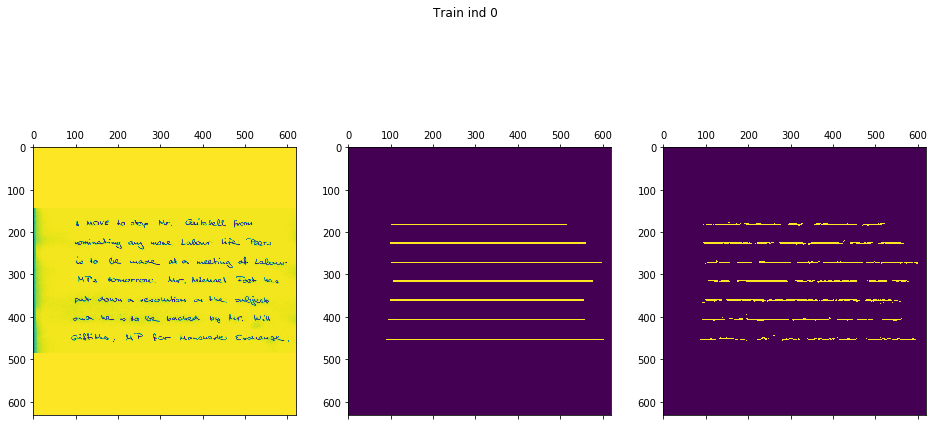

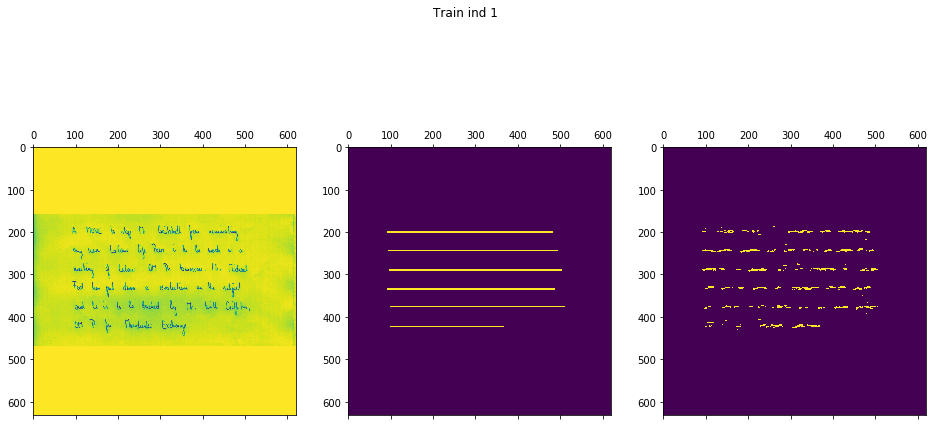

In [103]:
def plot_gt_and_pred(ind, X, Y, preds, title):
    sample_input = np.expand_dims(X[ind], 0)
    gt = Y[ind].argmax(-1)
    pred = preds[ind].argmax(-1)
    fig = plt.figure(figsize=(16,8))
    fig.suptitle(title)
    ax1 = fig.add_subplot(131)
    ax1.matshow(X[ind].squeeze())
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt)
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred)

preds = model.predict(X_train[:10])
for ind in range(10):
    plot_gt_and_pred(ind, X_train, Y_train, preds, f'Train ind {ind}')
    
preds = model.predict(X_test[:10])
for ind in range(10):
    plot_gt_and_pred(ind, X_test, Y_test, preds, f'Test ind {ind}')